In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.18.2
numpy: 1.19.4
astropy 4.0
regions 0.4


In [3]:
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

## Load data

In [4]:
datastore = DataStore.from_dir("/Users/jean/Documents/Phd_work/Results/gammapy4/data/std_impact/")
obs_ids = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
observations = datastore.get_observations(obs_ids)

## Define Target Region

In [5]:
target_position = SkyCoord(ra=44.544, dec=-8.958, unit="deg", frame="icrs")
on_region_radius = Angle("0.071 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Create exclusion mask

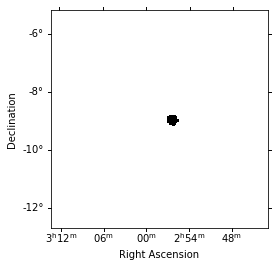

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(44.106, -8.98981, unit="deg", frame="icrs"),
    radius=0.2 * u.deg,
)

skydir = target_position.icrs
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();

## Run Data reduction

#### Maker configuration

In [7]:
e_reco = MapAxis.from_energy_bounds(0.1, 40, 40, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [8]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [9]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 4.06 s, sys: 104 ms, total: 4.16 s
Wall time: 4.23 s


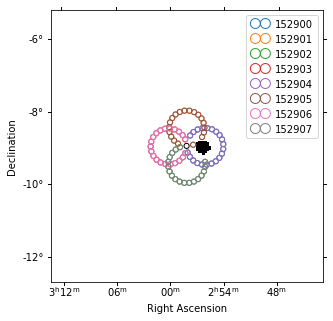

In [10]:
plt.figure(figsize=(5, 5))
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

### Source statistics

In [11]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str6,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
152900,17.0,3.6666666666666665,13.333333333333334,4.8368786855341055,4.272727272727272,4.272727272727272,nan,10144.526180877652,792109001.0606071,1682.0,1682.0,0.010107015457788348,0.002179944510503369,0.00792707094728498,40,31,wstat,37.29890965671227,77.0,31.0,651.0,0.04761904761904763
152900,40.0,7.456140518188477,32.543861389160156,7.934492695243932,8.991198655799753,8.991198655799753,nan,1170.7779079708648,1359161273.8309197,3364.0,3364.0,0.011890606420927468,0.002216450808022734,0.00967415617989303,40,33,wstat,83.79169971413958,149.0,33.0,659.4564819335938,0.04980776458978653
152900,64.0,12.233919143676758,51.766082763671875,9.905194919897074,14.777151198262914,14.777151198262914,nan,0.002487016987560251,1867654656.5027533,5046.0,5046.0,0.012683313515655966,0.0024244786253818386,0.010258835268266325,40,34,wstat,119.67988422773969,235.0,34.0,653.1022338867188,0.051807474344968796
152900,91.0,17.32915687561035,73.67084503173828,11.84623690959393,20.879283143819816,20.879283143819816,nan,85.05221843673756,2245733805.976443,6728.0,6728.0,0.013525564803804993,0.0025756773001798976,0.010949887787119245,40,35,wstat,166.26394962249165,342.0,35.0,690.7433471679688,0.050484877079725266
152900,128.0,23.948204040527344,104.05179595947266,14.173342404326714,28.894673293424468,28.894673293424468,nan,658.5569055251375,2541684458.9934177,8410.0,8410.0,0.015219976218787158,0.0028475866873397555,0.012372389531447403,40,36,wstat,232.66435188196385,481.0,36.0,723.0604858398438,0.04976743087172508
152900,151.0,29.68504524230957,121.31495666503906,15.042556577634258,35.501477152317946,35.501477152317946,nan,2966.595100092888,2810515419.7387705,9862.0,9862.0,0.015311295883187994,0.0030100431192769794,0.012301252957314851,40,36,wstat,271.16002913456674,590.0,36.0,715.5117797851562,0.05023426562547684
152900,175.0,35.16123580932617,139.83876037597656,16.034956254967142,41.82516371196311,41.82516371196311,nan,6812.464214634756,3144232664.241964,11544.0,11544.0,0.015159390159390159,0.0030458450978279776,0.012113544731113701,40,36,wstat,315.6403861674596,705.0,36.0,721.817626953125,0.049876537173986435
152900,188.0,37.605682373046875,150.39431762695312,16.6500426978895,44.80796402530895,44.80796402530895,nan,8128.4644084275515,3284236449.514126,12240.0,12240.0,0.015359477124183006,0.0030723596710005617,0.012287117453182445,40,36,wstat,334.1002926322808,749.0,36.0,717.019287109375,0.050130099058151245


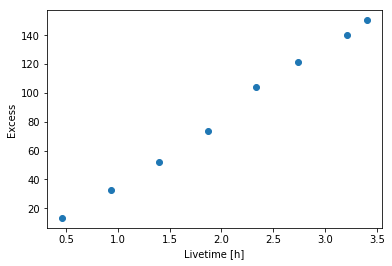

In [12]:
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

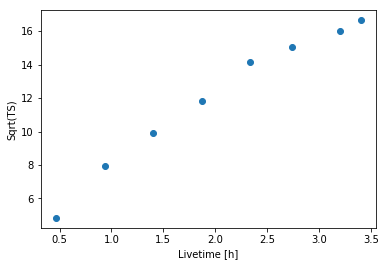

In [13]:
plt.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

In [14]:
print('Run   Threshold [TeV]')

for obs,ds in zip(observations, datasets):
    print(obs.obs_id, ds.energy_range[0])

info_table = datasets.info_table(cumulative = True)
print("Table of source statistics:\n")
print(info_table)


Run   Threshold [TeV]
152900 0.3850024543056701 TeV
152901 0.2853385818766556 TeV
152902 0.24564560522315815 TeV
152903 0.21147425268811285 TeV
152904 0.18205642030260805 TeV
152905 0.18205642030260805 TeV
152906 0.18205642030260805 TeV
152907 0.18205642030260805 TeV
Table of source statistics:

 name  counts     background     ...   acceptance_off         alpha        
                                 ...                                       
------ ------ ------------------ ... ----------------- --------------------
152900   17.0 3.6666666666666665 ...             651.0  0.04761904761904763
152900   40.0  7.456140518188477 ... 659.4564819335938  0.04980776458978653
152900   64.0 12.233919143676758 ... 653.1022338867188 0.051807474344968796
152900   91.0  17.32915687561035 ... 690.7433471679688 0.050484877079725266
152900  128.0 23.948204040527344 ... 723.0604858398438  0.04976743087172508
152900  151.0  29.68504524230957 ... 715.5117797851562  0.05023426562547684
152900  175.0  35.1

In [15]:

print(
    'Excess: '+str(info_table['excess'][-1]) + '\n', 'On Events: ' + str(info_table['counts'][-1])+'\n',
 'Off Events: '+str( info_table['counts_off'][-1]) + '\n', 'Livetime: ' + str(info_table['livetime'][-1]/3600) + '\n',
 'Alpha: ' + str(info_table['alpha'][-1]) + '\n', 'Background: ' + str(info_table['background'][-1]) + '\n',
  'Background_rate: '+ str(info_table['background_rate'][-1])+'\n', 'Excess rate: ' + str(info_table['excess_rate'][-1]) + '\n',
 'Excess/background: ' +str(info_table['excess'][-1]/info_table['background'][-1]) + '\n', 'Significance: ' + str(info_table['sqrt_ts'][-1])
 )

Excess: 150.39431762695312
 On Events: 188.0
 Off Events: 749.0
 Livetime: 3.4
 Alpha: 0.050130099058151245
 Background: 37.605682373046875
 Background_rate: 0.0030723596710005617
 Excess rate: 0.012287117453182445
 Excess/background: 3.9992444794658284
 Significance: 16.6500426978895


In [16]:
path = Path("1D_spectrum_analysis")
path.mkdir(exist_ok=True)

In [17]:
for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

/Users/jean/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [18]:
datasets = Datasets()
for obs_id in obs_ids:
    filename = path / f"pha_obs{obs_id}.fits"
    datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

## Fit Spectrum

In [19]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=0.55 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="grb")

for dataset in datasets:
    dataset.models = model

fit_joint = Fit(datasets)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model.copy()

In [20]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 65
	total stat : 164.25



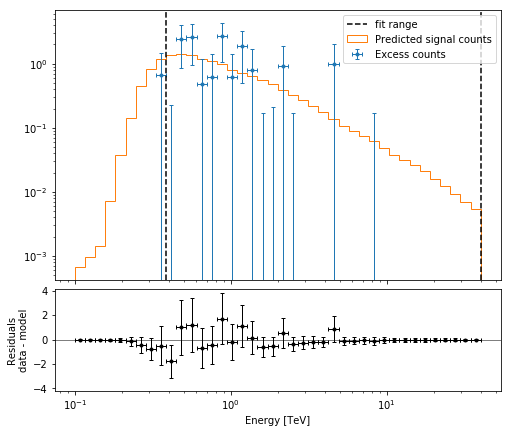

In [21]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
#ax_spectrum.set_ylim(0.01, 40)

### Compute Flux Points


In [22]:
e_min, e_max = 0.178, 30
energy_edges = np.logspace(np.log10(e_min), np.log10(e_max), 18) * u.TeV

In [23]:
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="grb")
with np.errstate(divide='ignore', invalid='ignore'):
        #flux_points = fpe.run(datasets=datasets)
        flux_points_joint = fpe.run(datasets=datasets)

In [24]:
flux_points_joint.table_formatted

counts [8],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0 .. 2,0.211,0.182,0.246,1.188e-10,7.601e-12,1.594e-12,5.313e-12,0.524,13.151,True,0.222,8.731,0.239,0.206,1.037,0.200 .. 5.000,15.880 .. 123.116,2.955,6.221e-11,1.232e-10,2.639e-11,2.841e-11,2.447e-11
0 .. 4,0.285,0.246,0.331,5.415e-11,4.674e-12,1.323e-12,4.409e-12,0.687,14.091,True,0.208,18.454,0.221,0.196,1.154,0.200 .. 5.000,21.762 .. 148.691,4.296,3.721e-11,6.250e-11,1.127e-11,1.195e-11,1.061e-11
0 .. 5,0.385,0.331,0.447,2.468e-11,2.875e-12,1.097e-12,3.658e-12,0.977,18.989,True,0.226,40.873,0.240,0.214,1.484,0.200 .. 5.000,39.248 .. 130.729,6.393,2.412e-11,3.662e-11,5.589e-12,5.915e-12,5.276e-12
6 .. 1,0.519,0.447,0.603,1.125e-11,1.768e-12,9.106e-13,3.035e-12,1.807,14.472,True,0.301,109.914,0.316,0.286,2.469,0.200 .. 5.000,83.230 .. 71.611,10.484,2.032e-11,2.777e-11,3.384e-12,3.554e-12,3.219e-12
2 .. 0,0.701,0.603,0.814,5.126e-12,1.087e-12,7.556e-13,2.519e-12,1.157,14.320,True,0.282,44.619,0.301,0.263,1.801,0.200 .. 5.000,37.503 .. 83.535,6.680,5.932e-12,9.230e-12,1.444e-12,1.545e-12,1.347e-12
4 .. 1,0.946,0.814,1.099,2.336e-12,6.685e-13,6.269e-13,2.090e-12,1.180,12.359,True,0.320,48.755,0.347,0.295,1.931,0.200 .. 5.000,33.865 .. 64.285,6.982,2.757e-12,4.512e-12,7.481e-13,8.112e-13,6.893e-13
3 .. 0,1.276,1.099,1.482,1.065e-12,4.111e-13,5.202e-13,1.734e-12,0.514,12.000,True,0.273,8.290,0.311,0.236,1.216,0.200 .. 5.000,13.992 .. 68.177,2.879,5.468e-13,1.295e-12,2.903e-13,3.311e-13,2.518e-13
0 .. 0,1.722,1.482,2.000,4.853e-13,2.528e-13,4.316e-13,1.439e-12,0.972,11.894,True,0.426,15.682,0.483,0.374,2.055,0.200 .. 5.000,18.659 .. 40.470,3.960,4.717e-13,9.974e-13,2.070e-13,2.342e-13,1.815e-13


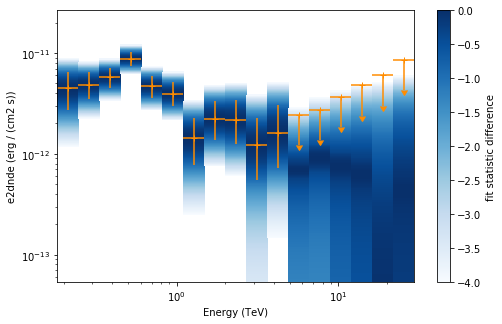

In [25]:
plt.figure(figsize=(8, 5))
flux_points_joint.table["is_ul"] = flux_points_joint.table["ts"] < 2
ax = flux_points_joint.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_joint.to_sed_type("e2dnde").plot_ts_profiles(ax=ax);

In [28]:
flux_points_joint_dataset = FluxPointsDataset(
    data=flux_points_joint, models=model_best_joint
)

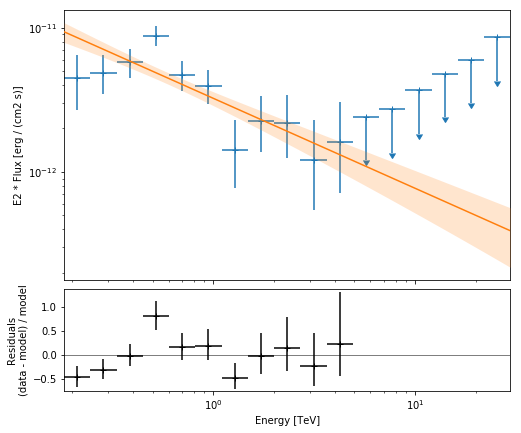

In [29]:
flux_points_joint_dataset.plot_fit();

In [30]:
dataset_stacked = Datasets(datasets).stack_reduce()

In [31]:
dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

In [32]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 24
	total stat : 35.86



In [33]:
model_best_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.6230e+00,,nan,nan,False,1.096e-01
amplitude,9.6834e-12,cm-2 s-1 TeV-1,nan,nan,False,8.873e-13
reference,5.5000e-01,TeV,nan,nan,True,0.000e+00


In [34]:
model_best_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.6314e+00,,nan,nan,False,1.093e-01
amplitude,9.7735e-12,cm-2 s-1 TeV-1,nan,nan,False,8.878e-13
reference,5.5000e-01,TeV,nan,nan,True,0.000e+00


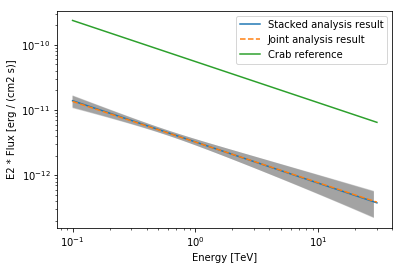

In [35]:
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

create_crab_spectral_model("hess_pl").plot(
    **plot_kwargs, label="Crab reference"
)
plt.legend()

In [36]:
fpe = FluxPointsEstimator(energy_edges = energy_edges, source="grb")
with np.errstate(divide='ignore', invalid='ignore'):
        #flux_points = fpe.run(datasets=datasets)
        flux_points_stacked = fpe.run(datasets=dataset_stacked)

In [37]:
flux_points_stacked.table_formatted

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
18,0.211,0.182,0.246,1.209e-10,7.734e-12,1.622e-12,5.406e-12,0.550,0.506,True,0.217,10.841,0.234,0.201,1.053,0.200 .. 5.000,4.000 .. 112.257,3.293,6.651e-11,1.273e-10,2.622e-11,2.826e-11,2.426e-11
30,0.285,0.246,0.331,5.495e-11,4.744e-12,1.342e-12,4.474e-12,0.708,0.341,True,0.204,21.250,0.217,0.193,1.167,0.200 .. 5.000,9.244 .. 136.868,4.610,3.891e-11,6.414e-11,1.124e-11,1.192e-11,1.058e-11
33,0.385,0.331,0.447,2.498e-11,2.910e-12,1.111e-12,3.703e-12,1.007,1.107,True,0.224,45.998,0.237,0.211,1.507,0.200 .. 5.000,24.326 .. 113.651,6.782,2.517e-11,3.765e-11,5.586e-12,5.910e-12,5.272e-12
45,0.519,0.447,0.603,1.136e-11,1.785e-12,9.196e-13,3.065e-12,1.784,1.694,True,0.298,107.531,0.313,0.284,2.440,0.200 .. 5.000,68.920 .. 60.325,10.370,2.026e-11,2.771e-11,3.385e-12,3.554e-12,3.221e-12
23,0.701,0.603,0.814,5.164e-12,1.095e-12,7.611e-13,2.537e-12,1.140,0.084,True,0.279,44.205,0.299,0.261,1.779,0.200 .. 5.000,22.783 .. 70.467,6.649,5.888e-12,9.185e-12,1.443e-12,1.544e-12,1.346e-12
17,0.946,0.814,1.099,2.347e-12,6.717e-13,6.299e-13,2.100e-12,1.146,0.557,True,0.321,35.494,0.347,0.296,1.894,0.200 .. 5.000,18.454 .. 53.440,5.958,2.690e-12,4.446e-12,7.528e-13,8.143e-13,6.939e-13
6,1.276,1.099,1.482,1.067e-12,4.120e-13,5.214e-13,1.738e-12,0.554,0.067,True,0.273,10.387,0.310,0.237,1.254,0.200 .. 5.000,2.722 .. 55.805,3.223,5.910e-13,1.338e-12,2.911e-13,3.313e-13,2.532e-13
7,1.722,1.482,2.000,4.852e-13,2.528e-13,4.315e-13,1.438e-12,0.974,0.507,True,0.429,13.828,0.485,0.378,2.061,0.200 .. 5.000,6.824 .. 29.011,3.719,4.725e-13,9.997e-13,2.083e-13,2.352e-13,1.833e-13


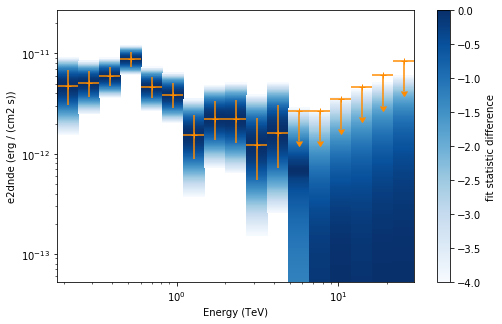

In [38]:
plt.figure(figsize=(8, 5))
flux_points_stacked.table["is_ul"] = flux_points_stacked.table["ts"] < 2
ax = flux_points_stacked.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points_stacked.to_sed_type("e2dnde").plot_ts_profiles(ax=ax);

In [39]:
flux_points_dataset_stacked = FluxPointsDataset(
    data=flux_points_stacked, models=model_best_stacked
)

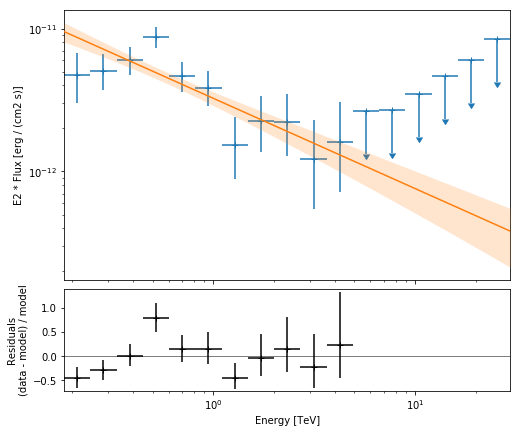

In [40]:
flux_points_dataset_stacked.plot_fit();

(1e-17, 1e-09)

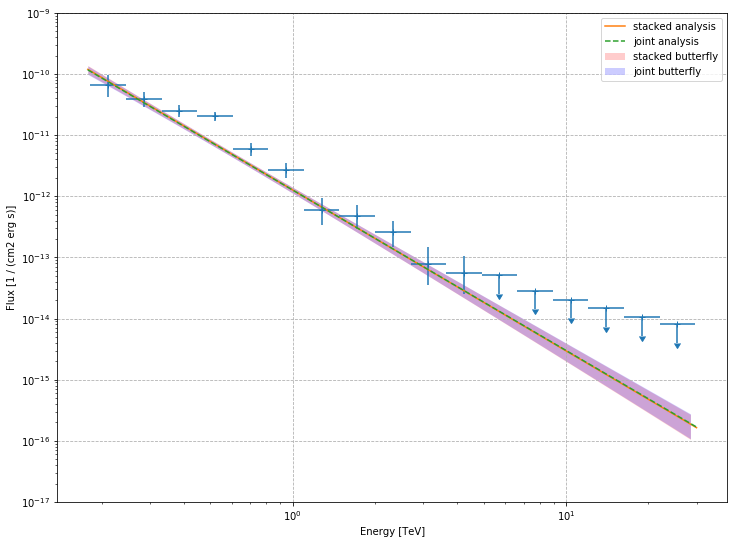

In [41]:
plot_kwargs = {"energy_range": [0.178, 30] * u.TeV, "flux_unit": "erg-1 cm-2 s-1",}
plt.figure(figsize=(12, 9))
ax1 = flux_points_stacked.plot()
model_best_stacked.spectral_model.plot(ax=ax1, **plot_kwargs, label = 'stacked analysis')
model_best_joint.spectral_model.plot(ax=ax1, **plot_kwargs, label = 'joint analysis', linestyle = '--')
model_best_stacked.spectral_model.plot_error(**plot_kwargs, label = 'stacked butterfly', color = 'red')
model_best_joint.spectral_model.plot_error(**plot_kwargs, label = 'joint butterfly', color = 'blue')

plt.legend()
ax1.grid(ls = '--')
ax1.set_ylim(10e-18, 10e-10)

In [42]:
print(flux_points_stacked.table_formatted)
print('')
# Print and save flux point results
print('Flux points')
print('Unit: TeV^-1 cm^-2 s^-1')
print('')
print('Energy [TeV]  |      Flux      |    Flux low    |    Flux high   |  Significance')
flux    = flux_points_stacked.table['dnde'].data
fluxerr = flux_points_stacked.table['dnde_err'].data
fluxul  = flux_points_stacked.table['dnde_ul'].data
sqrtts  = flux_points_stacked.table['sqrt_ts'].data
isul    = sqrtts < 2
for e,f,fl,fh,lim,ul,s in zip(flux_points_stacked.table['e_ref'], flux, flux-fluxerr, flux+fluxerr, fluxul, isul, sqrtts):
    if ul:
        print('{:^14.3f}|{:^16s}|{:16s}|{:16s}|{:^16.2f}'.format(e, '< {:.4g}'.format(lim), ' ', ' ', s))
    else:
        print('{:^14.3f}|{:^16.4g}|{:^16.4g}|{:^16.4g}|{:^16.2f}'.format(e, f, f-fl, f+fh, s))

counts [1] e_ref  e_min  e_max  ...    dnde_errp       dnde_errn    is_ul
            TeV    TeV    TeV   ... 1 / (cm2 s TeV) 1 / (cm2 s TeV)      
---------- ------ ------ ------ ... --------------- --------------- -----
        18  0.211  0.182  0.246 ...       2.826e-11       2.426e-11 False
        30  0.285  0.246  0.331 ...       1.192e-11       1.058e-11 False
        33  0.385  0.331  0.447 ...       5.910e-12       5.272e-12 False
        45  0.519  0.447  0.603 ...       3.554e-12       3.221e-12 False
        23  0.701  0.603  0.814 ...       1.544e-12       1.346e-12 False
        17  0.946  0.814  1.099 ...       8.143e-13       6.939e-13 False
         6  1.276  1.099  1.482 ...       3.313e-13       2.532e-13 False
         7  1.722  1.482  2.000 ...       2.352e-13       1.833e-13 False
         5  2.323  2.000  2.699 ...       1.438e-13       1.070e-13 False
         2  3.135  2.699  3.641 ...       6.826e-14       4.263e-14 False
         2  4.229  3.641  4.913 ...   

In [43]:
def my_residuals(self, method = "diff"):
    fp = self.data
    data = fp.table[fp.sed_type]

    model = self.flux_pred()

    residuals = self._compute_residuals(data, model, method)
    # Remove residuals for upper_limits
    residuals[fp.is_ul] = np.nan

    fp = self.data

    model = self.flux_pred()
    yerr = fp._plot_get_flux_err(fp.sed_type)

    if method == "diff":
        unit = yerr[0].unit
        yerr = yerr[0].to_value(unit), yerr[1].to_value(unit)
    elif method == "diff/model":
        unit = ""
        yerr = (yerr[0] / model).to_value(""), (yerr[1] / model).to_value(unit)
    else:
        raise ValueError("Invalid method, choose between 'diff' and 'diff/model'")

    return residuals, yerr

In [45]:
flux_points_dataset_stacked.residuals = my_residuals
residuals , res_err = flux_points_dataset_stacked.residuals(flux_points_dataset_stacked, method = "diff/model")
flux_points_stacked.table["residuals"] = residuals
flux_points_stacked.table["res_errd"] = res_err[0]
flux_points_stacked.table["res_erru"] = res_err[1]
flux_points_stacked.table['is_ul'] = flux_points_stacked.table['sqrt_ts'] < 2 # set threshold to 2 sigma
flux_points_stacked.write('reflectedbkg_night1_reanalysed'+'_flux_points_v18.ecsv',
                  include_names=['e_ref', 'e_min', 'e_max',
                                'dnde', 'dnde_err', 'dnde_errp', 'dnde_errn', 'dnde_ul',
                                'is_ul', 'sqrt_ts',"residuals","res_errd","res_erru"],
                  overwrite=True)